In [1]:
from madgwickahrs import * 
from quaternion import Quaternion
from conversion import * 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import norm
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


In [2]:
def conj(q):
    return [q[0], -q[1], -q[2], -q[3]]

def to_euler_angles(self):
    pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
    if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
        roll = 0
        yaw = 2 * np.arctan2(self[1], self[0])
    elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
        roll = -2 * np.arctan2(self[1], self[0])
        yaw = 0
    else:
        roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
        yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
    return roll, pitch, yaw

## Real Data

In [3]:
dt = 0.0001

file_object  = open("trajectory2.txt","r")
px = []
py = []
pz = []
vx = []
vy = []
vz = []
time = []
Ax = []
Ay = []
Az = []

count = 0 
for i in file_object:
    if count > 5999: 
        pass
    else:
        sp = i.split()
        time.append(sp[0])
        px.append(float(sp[1]))
        py.append(float(sp[2]))
        pz.append(float(sp[3]))
        vx.append(float(sp[4]))
        vy.append(float(sp[5]))
        vz.append(float(sp[6]))
        Ax.append(float(sp[7]))
        Ay.append(float(sp[8]))
        Az.append(float(sp[9]))
    count = count + 1
    

print(len(Ax))



6000


In [4]:
def calculateVelocity(p):
    vel = []
    for i in range(len(p)):
        if i == 0: 
            pass
        else: 
            vel.append((p[i]-p[i-1])/dt)
    return vel

def calculateAcceleration(v):
    acc = []
    for i in range(len(v)):
        if i ==0:
            pass
        else:
            acc.append((v[i]-v[i-1])/dt)
    return acc

# VX = calculateVelocity(px)
# AX = calculateAcceleration(vx)


def calculateVfromA(a, v0): 
    vel = []
    v = v0
    vel.append(v)
    for i in range(len(a)):
        v = v + a[i]*dt
        vel.append(v)
    

    
    return vel

def calculatePfromV(v, p0):
    pos = []
    p = p0
    pos.append(p)
    for i in range(len(v)):
        p = p + v[i]*dt
        pos.append(p)
        

    return pos



In [5]:
print(vx[0:10])
print(vy[0:10])

[30.7952538869, 30.8130772768, 30.8308860918, 30.8486803241, 30.8664599655, 30.884225008, 30.9019754436, 30.9197112642, 30.937432462, 30.9551390288]
[-20.9180481004, -20.9195558311, -20.9210560769, -20.9225488372, -20.9240341115, -20.9255118989, -20.926982199, -20.928445011, -20.9299003344, -20.9313481684]


In [6]:
## Calculate the Magnitude of V 
print(len(vx))
print(len(vy))

v = np.sqrt(np.array(vx)**2 + np.array(vy)**2)

6000
6000


## IMU Data

In [7]:
file_object  = open("imu_values2.txt","r")

dt = 0.0001

ax = []
ay = []
az = []
gx = []
gy = []
gz = []
magx = []
magy = []
magz = []

count = 0
for i in file_object:
    if count > 5999:
        pass
    else: 
        sp = i.split()
        ax.append(float(sp[1]))
        ay.append(float(sp[2]))
        az.append(float(sp[3]))
        gx.append(float(sp[4]))
        gy.append(float(sp[5]))
        gz.append(float(sp[6]))
        magx.append(float(sp[7]))
        magy.append(float(sp[8]))
        magz.append(float(sp[9]))
    count = count + 1

print(len(ax))
    
Acc = np.hstack([np.array(ax)[np.newaxis].T, np.array(ay)[np.newaxis].T, np.array(az)[np.newaxis].T])
Gyro = np.hstack([np.array(gx)[np.newaxis].T, np.array(gy)[np.newaxis].T, np.array(gz)[np.newaxis].T])
Mag = np.hstack([np.array(magx)[np.newaxis].T, np.array(magy)[np.newaxis].T, np.array(magz)[np.newaxis].T])


6000


In [8]:
## TODO:  yprchange
rollrate = np.array(gx)
pitchrate = np.array(gy)
yawrate = np.array(gz)
print(len(rollrate))

6000


## AHRS

In [9]:

frequency = 1000
sampleperiod = 1/frequency

rot_mat = []
Imupredict = MadgwickAHRS()
Imupredict.sampleperiod = sampleperiod
roll = []
pitch = []
yaw = []

for i in range(len(ax)):
#     Imupredict.update(Gyro[i], Acc[i], Mag[i])
    Imupredict.update_imu(Gyro[i], Acc[i])
    q = Imupredict.quaternion
#     rot_mat.append( np.transpose(quaterniontorotmatrix(q)))

    rot_mat.append( quaterniontorotmatrix(q))

    q1 = conj(q)
    q2 = to_euler_angles(q1)
    roll.append(q2[0])
    pitch.append(q2[1])
    yaw.append(q2[2])
#     roll.append(q2[0]*180/math.pi)
#     pitch.append(q2[1]*180/math.pi)
#     yaw.append(q2[2]*180/math.pi)
    
#     print(np.transpose(quaterniontorotmatrix(q)))



In [10]:
dt    = 0.0001 # Sample Rate of the Measurements is 50Hz
dtGPS = 0.0001 # Sample Rate of GPS is 10Hz
numstates = 8

# Kalman Filter Design

In [11]:
print(max(Ax))
print(max(Ay))
print(max(rollrate)) #gx in rad/s
print(max(pitchrate)) #gy in rad/s
print(max(yawrate)) #gz in rad/s

178.306745694
128.688349801
5.89739844942
0.674090050442
0.91641487381


[0, 0.003080416700001365, 0.003082198299999561, 0.0030839783999994097, 0.003085757200000927]
[0.0, 0.0, 0.006162615000000926, 0.006162615000000926, 0.012332350600001263]
[0.0, 0.0, -0.0041839109200001445, -0.0041839109200001445, -0.00836842044000008]
[0.0, 0.0, 0.0005367835110000052, 0.0005367835110000052, 0.0010741879060000015]


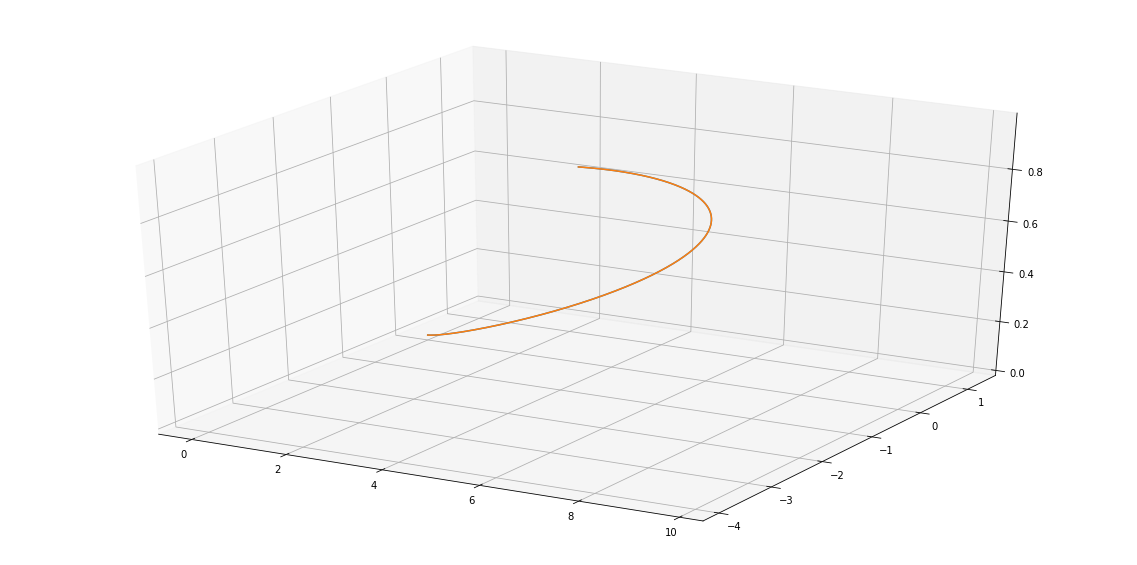

In [12]:
dx = []
dy = []
dz = []


for i in range(len(px)):
    if i ==0:
        dx.append(0)
        dy.append(0)
        dz.append(0)
    else:
        dx.append(px[i]-px[i-1])
        dy.append(py[i]-py[i-1])
        dz.append(pz[i]-pz[i-1])

        
print(dx[0:5])


mx = np.cumsum(dx)
my = np.cumsum(dy)
mz = np.cumsum(dz)


count = 0
mx2 = []
storex = 0
my2 = []
storey = 0
mz2 = []
storez = 0
for i in range(len(mx)):
    if count == 0:
        storex = mx[i]
        storey = my[i]
        storez = mz[i]
        mx2.append(storex)
        my2.append(storey)
        mz2.append(storez)
        count = 1
    else: 
        mx2.append(storex)
        my2.append(storey)
        mz2.append(storez)
        count = count -1 
        
print(mx2[0:5])
print(my2[0:5])
print(mz2[0:5])

mx = mx2
my = my2
mz = mz2


    


ds = np.sqrt(np.array(dx)**2 + np.array(dy)**2 + np.array(dz)**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter
# print(len(px))
# print(len(ax))
# print(len(dx))
# print(len(mx))
# print(len(GPS))
# print(dx[0:5])
# print(mx[0:5])

    
fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.plot(mx, my, mz)
axplot.plot(mx2, my2, mz2)


plt.show()

In [39]:
print(vx[0:5])
print(vy[0:5])
dvx = np.array(vx)
print(len(dvx))
dvy = np.array(vy)
print(len(dvy))
dv = np.sqrt(dvx**2 + dvy**2)
print(dv[0:10])

dvfromp = []
for i in range(len(px)):
    if i ==0: 
        pass
    else: 
        dvfromp.append(np.sqrt((px[i]- px[i-1])**2 + (py[i]-py[i-1])**2)/dt)
        
print(dvfromp[0:10])
print("Checked that the velocity calculated from p and v are the same")


print("Calculating heading from, vx, vy, v")

dheading_cal_from_vx = []
dheading_cal_from_vy = []
for i in range(len(dvx)):
    dheading_cal_from_vx.append(np.arccos(dvx[i]/dv[i]))
    dheading_cal_from_vy.append(np.arcsin(dvy[i]/dv[i]))

print(dheading_cal_from_vx[0:5])
print(dheading_cal_from_vy[0:5])


print("Calculate heading from position")
dheading_cal_from_p = []
for i in range(len(px)):
    if i ==0: 
        pass
    else:
        dheading_cal_from_p.append(math.atan2((py[i]-py[i-1]),(px[i]- px[i-1])))
print(dheading_cal_from_p[0:5])

print("calculate vx and vy from heading calculated from position")
dvx_from_p = []
dvy_from_p = []
for i in range(len(dheading_cal_from_p)):
    dvx_from_p.append(dvfromp[i]*cos(dheading_cal_from_p[i]))
    dvy_from_p.append(dvfromp[i]*sin(dheading_cal_from_p[i]))
print(dvx_from_p[0:5])
print(dvy_from_p[0:5])

print(vx[0:5])
print(vy[0:5])


[30.7952538869, 30.8130772768, 30.8308860918, 30.8486803241, 30.8664599655]
[-20.9180481004, -20.9195558311, -20.9210560769, -20.9225488372, -20.9240341115]
6000
6000
[37.22784439 37.2434363  37.259014   37.2745775  37.29012677 37.3056618
 37.32118259 37.33668913 37.3521814  37.36765939]
[37.235641619052636, 37.25122634612254, 37.26679651004996, 37.28235376203655, 37.29789478748626, 37.31342377729449, 37.32893647600977, 37.34443713184009, 37.35992154423997, 37.375392137648426]
Checked that the velocity calculated from p and v are the same
Calculating heading from, vx, vy, v
[0.5966718873302853, 0.5964364735088239, 0.5962013101467653, 0.5959663967524194, 0.595731732843517]
[-0.5966718873302855, -0.596436473508824, -0.5962013101467651, -0.5959663967524192, -0.5957317328435171]
Calculate heading from position
[-0.596554148470209, -0.596318861755896, -0.5960838312687435, -0.5958490262932682, -0.5956145064575895]
calculate vx and vy from heading calculated from position
[30.8041670000136, 3

In [ ]:
print(max(dx))
print(max(dy))
print(max(dz))
print(min(dz))
print(min(vx))
print(max(vy))
print(min(pitch))
print(max(pitch))
print(min(pitchrate))
print(max(pitchrate))

In [ ]:
vs, vxs, vys, vzs, psis, dpsis, dts, xs, ys, zs, axs, ays, azs, phis, dphis, thetas, dthetas, Lats, Lons = \
 symbols('v, v_x, v_y, v_z \psi \dot\psi T x y z a_x, a_y, a_z, \phi \dot\phi \Theta \dot\Theta Lat Lon')

As = Matrix([[xs+(vxs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+((vxs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))) + ((vys/dphis)*(sin(phis+dphis*dts)-sin(phis)))],
             [zs+(vys/dphis)*(-cos(phis+dphis*dts)+cos(phis))],
             [vxs + axs*dts],
             [vys + ays*dts],
             [psis+dpsis*dts],
             [thetas+dthetas*dts],
             [phis+dphis*dts]])
state = Matrix([xs,ys,zs,vxs,vys,psis,thetas,phis])

In [ ]:
As

In [ ]:
state

In [ ]:
As.jacobian(state)

In [ ]:
control = Matrix([axs, ays, dpsis, dthetas,dphis ])
control

In [ ]:
JGs = As.jacobian(control)
JGs

In [ ]:
hs = Matrix([[xs],[ys],[zs],[vxs],[vys],[psis],[thetas],[phis]])
Hs=hs.jacobian(state)
Hs

In [ ]:
vx = []

for i in range(len(v)):
    vx.append(cos(yaw[i]))
    vy.append(sin(yaw[i]))
    
    

In [ ]:
cos(-0.21)

## Q: Process Noise 

In [ ]:

# pitchrateaccmax=  3.49 # rad/s2
# rollrateaccmax =  3.49 # rad/s2
# yawrateaccmax  =  1.396  *np.pi/180.0 # rad/s2

Q = np.diagflat([[dt*3],            # acceleration
                 [dt*3],            # acceleration
            [dt*0.02],           # yawrate
            [dt*0.03],         # pitchrate
            [dt*0.03]])         # rollrate





# Q = np.diagflat([[6],            # acceleration
#             [6],
#             [(0.028)**2],           # yawrate
#             [(0.070)**2],         # pitchrate
#             [(0.070)**2]])         # rollrate

## R: Measurement Noise Covariance
## TODO: R could be different

In [ ]:
R = np.diagflat([[(0.0004)**2],      # x
            [(0.0004)**2],           # y
            [(0.0004)**2],           # y
            [(0.001)**2],  # v
            [(0.001)**2],  # v
            [(0.05)**2],  # heading 
            [(0.05)**2],  # pitch
            [(0.05)**2]]) # roll

In [ ]:
speed = np.array(vx)
print(len(vx))
print(len(ax))

In [ ]:
## Change these values 

In [ ]:
epe = (np.zeros(np.shape(ax))+1)*3

epsilon = 0.1
xi      = 500.0
zeta    = 50.0
spspeedx=xi/((np.array(vx)/1.0)+epsilon)
spspeedy=xi/((np.array(vy)/1.0)+epsilon)

spepe=zeta*epe
spx = (spspeedx)**2 + (spepe)**2
spy = (spspeedy)**2 + (spepe)**2


print(spspeedx)
print(spspeedy)
print(spx)
print(spy)



In [ ]:
az = np.array(az)
ax = np.array(ax)
ay = np.array(ay)

rho = 200.0
gamma=500.0

sroll = (rho + gamma*ay)**2
spitch= (rho + gamma*ax)**2
syaw = (rho + gamma*az)**2

print(sroll)
print(spitch)

## I

In [ ]:
I = np.eye(numstates)
print(I, I.shape)

In [ ]:
###############3

## Initial State

In [ ]:
x = np.matrix([[mx[0], my[0], mz[0], v[0]/1.0, v[0]/1.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

U=float(np.cos(x[5])*x[3])
V=float(np.sin(x[5])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

## Initial Uncertainty

In [ ]:
## TODO: see how this value changes the result
P = 1e-4*np.eye(numstates)
print(P)

# P = np.array([[1e-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
#               [0.0,1e-4,0.0,0.0,0.0,0.0,0.0,0.0],
#               [0.0,0.0,1e-4,0.0,0.0,0.0,0.0,0.0],
#               [0.0,0.0,0.0,1e-4,0.0,0.0,0.0,0.0],
#               [0.0,0.0,0.0,0.0,1e-4,0.0,0.0,0.0],
#               [0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0],
#               [0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0],
#               [0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0]])

print(P)
    

## Measurement Vector

In [ ]:
mx = np.array(mx)
my = np.array(my)
mz = np.array(mz)
vx = np.array(vx)
vy = np.array(vy)
yaw = np.array(yaw)
pitch = np.array(pitch)
roll = np.array(roll)

measurements = np.vstack((mx, my, mz, \
                          vx/1.0, \
                          vy/1.0, \
                          yaw, \
                          pitch, \
                          roll))

# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

In [ ]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
Zx = []
Zy = []
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []
K0 = []
K1 = []
K2 = []
K3 = []
K4 = []
K5 = []
K6 = []
K7 = []
dstate=[]

h0 = []
h1 = []
h2 = []

In [ ]:
print(mx[0])
print(my[0])
print(mz[0])
print(x[0])
print(x[1])
print(x[2])
print(measurements[0])
print(m)
ri = 6000
x0.append(float(x[0]))
x1.append(float(x[1]))
x2.append(float(x[2]))
print(x0)
print(x1)
print(x2)
h0.append(x[0])
h1.append(x[1])
h2.append(x[2])

In [ ]:

for filterstep in range(ri):

    axc = ax[filterstep]
    ayc = ay[filterstep]
    yawc = yawrate[filterstep]
    pitc = pitchrate[filterstep]
    rolc = rollrate[filterstep]    
    
#     print("old")
#     print(x[0])
#     print(x[1])
#     print(x[2])
    
    if yawc==0.0: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[5])
        x[1] = x[1] + x[3]*dt * np.sin(x[5]) + x[4]*dt * np.cos(x[7])  
        x[2] = x[2] + x[4]*dt * np.sin(x[7])
        x[3] = x[3] + axc*dt
        x[4] = x[4] + ayc*dt
        x[5] = x[5] + yawc*dt
        x[6] = x[6] + pitc*dt
        x[7] = x[7] + rolc*dt
        yawc = 0.00000001 # to avoid numerical issues in Jacobians
        rolc = 0.00000001 # to avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5]))
        x[1] = x[1] + ((x[3]/yawc) * (-np.cos(yawc*dt+x[5])+ np.cos(x[5]))) + ((x[4]/rolc) * (np.sin(rolc*dt+x[7])- np.sin(x[7])))
        x[2] = x[2] + ((x[4]/rolc) * (-np.cos(rolc*dt+x[7])+ np.cos(x[7])))
        x[3] = x[3] + axc*dt
        x[4] = x[4] + ayc*dt
        x[4] = (x[4] + yawc*dt + np.pi) % (2.0*np.pi) - np.pi
        x[5] = x[5] + pitc*dt
        #x[6] = x[6] + rolc*dt
        x[6] = (x[6] + rolc*dt + np.pi) % (2.0*np.pi) - np.pi
        dstate.append(1)
#     print("predicted")
#     print(x[0]) 
#     print(x[1])
#     print(x[2])
    
    
    a14 = float((1.0/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5])))
    a16 = float((x[3]/yawc)* (np.cos(yawc*dt+x[5]) - np.cos(x[5])))
    a24 = float((1.0/yawc) * (-np.cos(yawc*dt+x[5]) + np.cos(x[5])))
    a25 = float((1.0/rolc) * (np.sin(rolc*dt+x[7]) - np.sin(x[7])))
    a26 = float((x[3]/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5])))
    a28 = float((x[4]/rolc)* (np.cos(rolc*dt+x[7]) - np.cos(x[7])))
    a35 = float((1/rolc)* (-np.cos(rolc*dt+x[7]) + np.cos(x[7])))
    a38 = float((x[4]/rolc)* (np.sin(rolc*dt+x[7]) - np.sin(x[7])))

    JA = np.matrix([[1.0, 0.0, 0.0, a14, 0.0, a16, 0.0, 0.0],
                  [0.0, 1.0, 0.0, a24, a25, a26, 0.0, a28],
                  [0.0, 0.0, 1.0, 0.0, a35, 0.0, 0.0, a38],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
#     print(np.shape(JA))
    
    
    g13 = float((dt*x[3]/yawc)*np.cos(yawc*dt+x[5]) - (x[3]/yawc**2)*(np.sin(yawc*dt+x[5])-np.sin(x[5])))
    g23 = float((dt*x[3]/yawc)*np.sin(yawc*dt+x[5]) - (x[3]/yawc**2)*(-np.cos(yawc*dt+x[5])+np.cos(x[5])))
    g25 = float((dt*x[4]/rolc)*np.cos(rolc*dt+x[7]) - (x[4]/rolc**2)*(np.sin(rolc*dt+x[7])-np.sin(x[7])))
    g35 = float((dt*x[4]/rolc)*np.sin(rolc*dt+x[7]) - (x[4]/yawc**2)*(-np.cos(rolc*dt+x[7])+np.cos(x[7])))
                
    JG = np.matrix([[0.0, 0.0, g13, 0.0, 0.0],
                    [0.0, 0.0, g23, 0.0, g25],
                    [0.0, 0.0, 0.0, 0.0, g35],
                    [dt, 0.0, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 0.0, dt]])
    
    # Project the error covariance ahead
    P = JA*P*JA.T + JG*Q*JG.T
    
#     print("predicted P")
#     print(P)
    
    
    # Measurement Update (Correction)
    # ===============================
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])],
                    [float(x[6])],
                    [float(x[7])]])
    # Because GPS is sampled with 10Hz and the other Measurements, as well as
    # the filter are sampled with 50Hz, one have to wait for correction until
    # there is a new GPS Measurement
    if GPS[filterstep]:
        #print("GPS")
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

        S = JH*P*JH.T + R    # R should be small and S should be small 

        K = (P*JH.T) * np.linalg.inv(S)

        # Update the estimate via
        z = measurements[:,filterstep].reshape(JH.shape[0],1)
        y = z - (hx)                         # Innovation or Residual
        x = x + (K*y)

        h0.append(z[0])
        h1.append(z[1])
        h2.append(z[2])

    #     # Update the error covariance
        P = (I - (K*JH))*P


#     else:

#         JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

    

    
# #     # Adaptive R
#     R[0,0] = spx[filterstep]       # x
#     R[1,1] = spy[filterstep]       # y
#     R[2,2] = spy[filterstep]
#     R[3,3] = spspeedx[filterstep]  # vx
#     R[4,4] = spspeedy[filterstep]
#     R[5,5] = syaw[filterstep]  # course
#     R[6,6] = spitch[filterstep]   # pitch
#     R[7,7] = sroll[filterstep]    # roll
    
    

#     print("P")
#     print(P)
#     if GPS[filterstep]:
#         x[0] = measurements[0][filterstep]
#         x[1] = measurements[1][filterstep]
#         x[2] = measurements[2][filterstep]
#         print("corrected")
#         print(x[0])
#         print(x[1])
#         print(x[2])
    
    
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    x6.append(float(x[6]))
    x7.append(float(x[7]))
    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    P6.append(float(P[6,6]))
    P7.append(float(P[7,7]))
    K0.append(float(K[0,0]))
    K1.append(float(K[1,0]))
    K2.append(float(K[2,0]))
    K3.append(float(K[3,0]))
    K4.append(float(K[4,0]))
    K5.append(float(K[5,0]))
    K6.append(float(K[6,0]))
    K7.append(float(K[7,0]))
    
    
    
    
    

In [ ]:
# num = 0
# print(mx[num])
# print(measurements[0][num])
# print(my[num])
# print(measurements[1][num])

# print(h0)
# print(mx)
# print(x0[0])
# print(x1[0])
# print(x2[0])

In [ ]:
# print(x0)
# print(x1)
# print(x2)
# print(mx[0:5])
# print(my[0:5])
# print(mz[0:5])

kx = mx[0:ri]
ky = my[0:ri]
kz = mz[0:ri]

fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.scatter( x1, x2, x0)
axplot.scatter( ky, kz, kx)
# axplot.plot(x0, x1, x2, label='trajectory')
# axplot.plot(h0, h1, h2)
# axplot.plot(kx, ky, kz)


axplot.legend()

plt.show()




In [ ]:
m = ri 
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),P0, label='$x$')
plt.step(range(m),P1, label='$y$')
plt.step(range(m),P2, label='$z$')
plt.step(range(m),P3, label='$vx$')
plt.step(range(m),P4, label='$vy$')
plt.step(range(m),P5, label='$\psi$')
plt.step(range(m),P6, label='$\Theta$')
plt.step(range(m),P7, label='$\phi$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,ri)
plt.title('Uncertainty (Elements from Matrix $P$)')
#plt.legend(loc='best',prop={'size':22})
plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
       ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.step(range(ri),K0, label='$x$')
plt.step(range(ri),K1, label='$y$')
plt.step(range(ri),K2, label='$z$')
plt.step(range(ri),K3, label='$vx$')
plt.step(range(ri),K4, label='$vy$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,ri)
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
#plt.legend(prop={'size':18})
plt.legend(bbox_to_anchor=(0., 0., 1., .102), loc=3,
       ncol=5, mode="expand", borderaxespad=0.,prop={'size':22})
plt.ylim([-0.4,0.4])

In [ ]:
## Process Noise Covarance Matrix Q